
# List 1

Krzysztof Jankowski


## Imports


In [26]:
import numpy as np
from pydantic import validate_call, PositiveInt
from enum import Enum, auto
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import logging

In [27]:
logger = logging.getLogger(__name__)

In [2]:
class State(Enum):
    positive = auto()
    negative = auto()

c0 <- initial concentration

c+ <- positive opinion

c- <- negative opinion

$$
c^+=\frac{1}{N}\sum^N_{i-1}\frac{(S_i+1)}{2}\in\bigl[0,1\bigr]
$$

$$
c^-=1-c^+
$$
$$
Pr(S_i(t=0)=1)=c_0
$$

In [3]:
class SznajdModel:
    @validate_call
    def __init__(self, n: int, t: int, c0: float) -> None:
        self.n = n
        self.t = t
        self.c0 = c0
    
    def run(self):
        self._pre_init_simulation()
        for i in range(self.t):
            self._update(i)
        
    def _pre_init_simulation(self) -> None:
        #Optimization stuff
        self.graph = self._init_graph()
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))
    
    def _init_graph(self) -> np.ndarray[State]:
        init = np.random.choice(list(State), size=self.n, p=[self.c0, 1 - self.c0])
        graph_evolution = np.ndarray((self.t+1, self.n), dtype=State)
        graph_evolution[0,:] = init
        return graph_evolution
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        an initial state. Therefore i-th update row corresponds with i-th + 1
        graph evolution row. 
        """
        self.graph[step+1,:] = self.graph[step,:]
        for substep in self.choice[step]:
            if self.graph[step+1][substep] == self.graph[step+1][(substep + 1) % self.n]:
                self._agreement_update(step+1, substep)
            else:
                self._disagreement_update(step+1, substep)
            
    
    def _agreement_update(self, step: int, pos: int) -> None:
        state = self.graph[step][pos]
        self.graph[step, (pos - 1) % self.n] = state
        self.graph[step, (pos + 2) % self.n] = state
    
    def _disagreement_update(self, step: int, pos: int) -> None:
        self.graph[step][(pos - 1) % self.n] = self.graph[step][(pos + 1) % self.n]
        self.graph[step][(pos + 2) % self.n] = self.graph[step][pos]
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)


In [4]:
class SznajdModel_v2(SznajdModel):
    """Do nothing variant"""
    def _disagreement_update(self, step: int, pos: int) -> None: ...
    

In [5]:
def task_2() -> None:
    n = 100
    t = 100
    c_inits = [0.25, 0.5, 0.75]
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True)
    for idx, c in enumerate(c_inits):
        model = SznajdModel(n, t, c)
        model.run()
        
        current_ax = axes.flatten()[idx]
        current_ax.imshow(model.get_graph_evolution(), cmap='viridis', interpolation='nearest')
        current_ax.set_title(f"USDF, $c_0={c}$")

    for idx, c in enumerate(c_inits):
        model = SznajdModel_v2(n, t, c)
        model.run()
        
        current_ax = axes.flatten()[idx + 3]
        current_ax.imshow(model.get_graph_evolution(), cmap='viridis', interpolation='nearest')
        current_ax.set_title(f"Do nothing, $c_0={c}$")
        current_ax.set_xlabel("State")
    axes.flatten()[0].set_ylabel("T")
    axes.flatten()[4].set_ylabel("T")
    fig.suptitle("Sznajd Model evolution")
    fig.tight_layout()
        

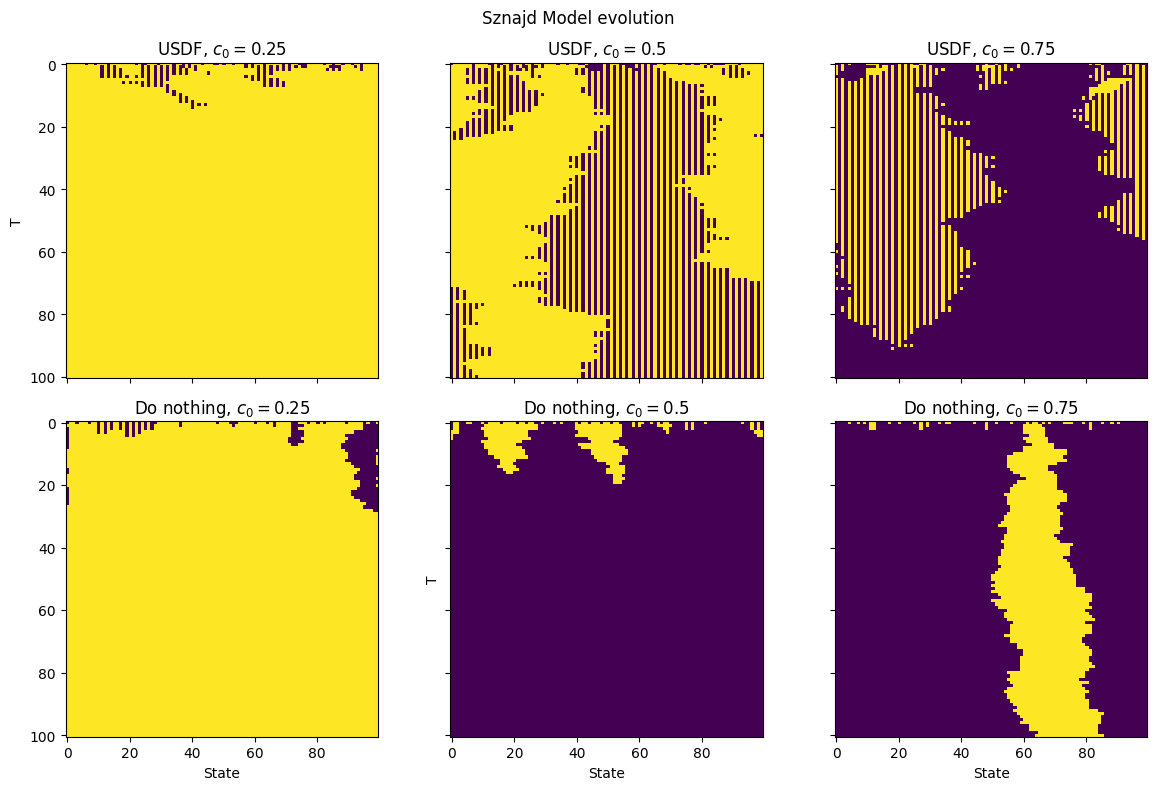

In [6]:
task_2()

In [7]:
class SznajdModel_v3(SznajdModel):
    
    def run_since_steady(self):
        """In that case t is used as a buffer size to, do not overwrite list 
        for each time. It is not a graceful feature, but reusing already 
        existing dimension.
        """
        self._pre_init_simulation()
        i = 0
        while not self._is_steady_state(i):
            self._update(i)
            i += 1
        self.steps_since_steady = i
        
    def _is_steady_state(self, step: int) -> bool:
        state = self.graph[step % (self.t + 1), 0]
        return all(state == s for s in self.graph[step % (self.t + 1), :])
        
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        graph evolution row.
        
        In this case we unify this update to allow endless operating since 
        steady state exciding. If the time axis is overriden we reiterate. 
        """
        if step >= len(self.graph):
            self._clear_cache()
        self.graph[(step+1) % (self.t + 1),:] = self.graph[step % (self.t + 1),:]
        for substep in self.choice[step % self.t]:
            if self.graph[(step+1) % (self.t + 1), substep] == self.graph[(step+1) % (self.t + 1), (substep + 1) % self.n]:
                self._agreement_update((step+1) % (self.t + 1), substep)
            else:
                self._disagreement_update((step+1) % (self.t + 1), substep)
            
    
    def _clear_cache(self):
        self.graph[0,:] = self.graph[self.t, :]
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))


In [8]:
class SznajdModel_v4(SznajdModel_v3):
    """Do nothing variant"""
    def _disagreement_update(self, step: int, pos: int) -> None: ...
    

In [16]:
model = SznajdModel_v4(n=100, t=100, c0=0.1)
model.run_since_steady()
model.steps_since_steady

45

In [24]:
def task3():
    n = 100
    buffer_size = 100
    c_inits = np.arange(0.0, 1.0, 0.05)
    runs_count = 100
    runs = defaultdict(list)
    for c in c_inits:
        print(f"Running simulations for c={c}...")
        model = SznajdModel_v4(n=n, t=buffer_size, c0=c)
        for _ in tqdm(range(runs_count)):
            model.run_since_steady()
            runs[c].append(model.steps_since_steady)
    return runs
        

In [ ]:
out = task3()

Running simulations for c=0.0...


100%|██████████| 100/100 [00:00<00:00, 1691.12it/s]


Running simulations for c=0.05...


100%|██████████| 100/100 [00:00<00:00, 264.88it/s]


Running simulations for c=0.1...


100%|██████████| 100/100 [00:01<00:00, 62.32it/s]


Running simulations for c=0.15000000000000002...


100%|██████████| 100/100 [00:01<00:00, 56.06it/s]


Running simulations for c=0.2...


100%|██████████| 100/100 [00:04<00:00, 21.43it/s]


Running simulations for c=0.25...


100%|██████████| 100/100 [00:06<00:00, 14.68it/s]


Running simulations for c=0.30000000000000004...


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Running simulations for c=0.35000000000000003...


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Running simulations for c=0.4...


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Running simulations for c=0.45...


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Running simulations for c=0.5...


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


Running simulations for c=0.55...


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Running simulations for c=0.6000000000000001...


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Running simulations for c=0.65...


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Running simulations for c=0.7000000000000001...


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Running simulations for c=0.75...


100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


Running simulations for c=0.8...


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


Running simulations for c=0.8500000000000001...


100%|██████████| 100/100 [00:03<00:00, 32.27it/s]


Running simulations for c=0.9...


100%|██████████| 100/100 [00:02<00:00, 40.58it/s]


Running simulations for c=0.9500000000000001...


100%|██████████| 100/100 [00:00<00:00, 899.89it/s]


defaultdict(list,
            {np.float64(0.0): [0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
             